<a href="https://colab.research.google.com/github/kyle-gao/GRSS_TrackMSD2021/blob/main/ChangeLabelMerging_OuterProduct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2 Land Cover Label to 1 mixed change label

Suppose we have 2 landcover labels with n classes for landcover change detection. We wish to produce a single land cover change label with ~n^2 classes. This operation should be **vectorized**.

Consider the following example from the GRSS contest 2021 

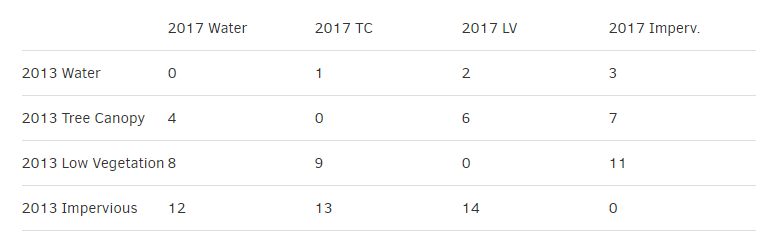

##Consider using tensor outer product
https://en.wikipedia.org/wiki/Outer_product



1.  One hot encode the categorical labels 
2.  Outer-product the two labels to produce a change map
3.  Use argmax to go back to categorical labels. 



In [1]:
import tensorflow as tf
import numpy as np

In [103]:
n_classes = 6
label_shape = (1,512,512,1)
np.random.seed(seed=10)

In [104]:
label1 = np.random.randint(low = 0, high=n_classes, size=label_shape)
label2 = np.random.randint(low = 0, high=n_classes, size=label_shape)

In [105]:
label1 [:,50,50,0] #using rank 4 tensors for (n,Height,Weight,1)

array([1])

##We one hot encode the labels

In [106]:
label1 = tf.one_hot(tf.cast(label1[:,:,:,0],dtype = tf.uint8),depth=n_classes)
label2 = tf.one_hot(tf.cast(label2[:,:,:,0],dtype = tf.uint8),depth=n_classes)

In [107]:
label1[:,50,50,:]

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[0., 1., 0., 0., 0., 0.]], dtype=float32)>

In [108]:
label2[:,50,50,:]

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[0., 0., 1., 0., 0., 0.]], dtype=float32)>

##Use tf.einsum to take the outer-product
einsum is a very useful operation available in numpy, pytorch and tensorflow that allows for fast implementations of arbitrary tensor contractions/products


The trick to use einsum is to view tensors operations as operations on elements of tensors.

Eg. matrix product of M and N: \\
$P_{ik} = \Sigma_j M_{ij} N_{jk}$

this is tf.einsum("ij,jk->ik", M,N)


In [109]:
#outer product over the one hot dimension

changelabel = tf.einsum("abcd,abce->abcde",label1,label2) 

The outer product is size (n,Height,Width,n_classes,n_classes) 

At each pixel, we will have a matrix of dimensions numclasses by numclasses, with a one hot encoding of the change label


We see that the element (50,50)'s label starts as 1 and goes to 2
So the 1sth row (not 0th) and 2nd column will have a 1, all other elemnts will be 0.




In [110]:
changelabel[0,50,50,:]

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)>

##Option 1: n_classes^2 classes in the change label*
For this, we can easily **flatten** the last 2 dimensions then use argmax to map the label back to categorical

In [111]:
changelabel2 = tf.reshape(changelabel,(label_shape[0],label_shape[1],label_shape[2],n_classes**2))
changelabel2 = tf.argmax(changelabel2,axis=-1)

In [112]:
changelabel2[0,50,50] #Note that the (1,2) th element of the matrix is the 8th element

<tf.Tensor: shape=(), dtype=int64, numpy=8>

##Option 2 n_classes^2-1 classes in the change label, follows the convention of the GRSS contest

Make a change array that labels entries of the change matrix so that the diagonal elements are 0. Other entries count up from 1

In [113]:
def make_label_change_array(num_classes):
  """Arg:
  num_classes:int, number of classes
  returns:
  num_classes^2 matrix of categorical change labels.
  """
  label_change_arr = np.zeros((num_classes,num_classes),dtype=np.uint8)
  i = 0
  for x in range(num_classes):
    for y in range(num_classes):
      label_change_arr[x,y] = i *(x!=y)
      i += 1
  return label_change_arr

label_change_arr = make_label_change_array(n_classes)

print(label_change_arr)

[[ 0  1  2  3  4  5]
 [ 6  0  8  9 10 11]
 [12 13  0 15 16 17]
 [18 19 20  0 22 23]
 [24 25 26 27  0 29]
 [30 31 32 33 34  0]]


use hadamard product and reduce sum to convert to categorical

In [114]:
changelabel = changelabel*label_change_arr
changelabel[0,50,50,:]

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 8., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [115]:
changelabel = tf.reduce_sum(changelabel,axis=[-1,-2])

In [116]:
changelabel[0,50,50] 

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

Note that the two approaches are not equivalent for 2nd row and beyond